In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.random.set_seed(
    42
)


import seaborn as sns

In [7]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [55]:
def display_mode_trainTestGraphs(results):
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']    
    train_prec = results.history['precision_2']
    train_recall = results.history['recall_2']
    
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']
    val_prec = results.history['val_precision_2']
    val_recall = results.history['val_recall_2']

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 5))
    
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
    sns.lineplot(x=results.epoch, y=train_prec, ax=ax3, label='train_precision')
    sns.lineplot(x=results.epoch, y=train_recall, ax=ax4, label='train_recall')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    sns.lineplot(x=results.epoch, y=val_prec, ax=ax3, label='val_precision')
    sns.lineplot(x=results.epoch, y=val_recall, ax=ax4, label='val_recall')
    
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    ax3.set_title('Precision')
    ax4.set_title('Recall')
    ax1.legend();

# Training Set

In [24]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=256,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [25]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=256,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [26]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=256,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

In [27]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 5,
                           restore_best_weights=True,
                           mode='min')

## Model 1 - Simple CNN

In [28]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 401408)            0         
                                                                 
 dense_2 (Dense)             (None, 8)                 3211272   
                                                                 
Total params: 3,211,592
Trainable params: 3,211,592
Non-trainable params: 0
_________________________________________________________________


In [29]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1
                    )

Epoch 1/50
192/192 [==============================] - 36s 183ms/step - loss: 1.3709 - accuracy: 0.7947 - precision_2: 0.8026 - recall_2: 0.7789 - val_loss: 0.8172 - val_accuracy: 0.7923 - val_precision_2: 0.7934 - val_recall_2: 0.7903
Epoch 2/50
192/192 [==============================] - 36s 185ms/step - loss: 0.5966 - accuracy: 0.8278 - precision_2: 0.8376 - recall_2: 0.8181 - val_loss: 0.8355 - val_accuracy: 0.7881 - val_precision_2: 0.7986 - val_recall_2: 0.7704
Epoch 3/50
192/192 [==============================] - 35s 184ms/step - loss: 0.5004 - accuracy: 0.8465 - precision_2: 0.8578 - recall_2: 0.8347 - val_loss: 0.7908 - val_accuracy: 0.7949 - val_precision_2: 0.8019 - val_recall_2: 0.7848
Epoch 4/50
192/192 [==============================] - 36s 185ms/step - loss: 0.4092 - accuracy: 0.8713 - precision_2: 0.8819 - recall_2: 0.8601 - val_loss: 0.8519 - val_accuracy: 0.7915 - val_precision_2: 0.8005 - val_recall_2: 0.7762
Epoch 5/50
192/192 [==============================] - 35s 18

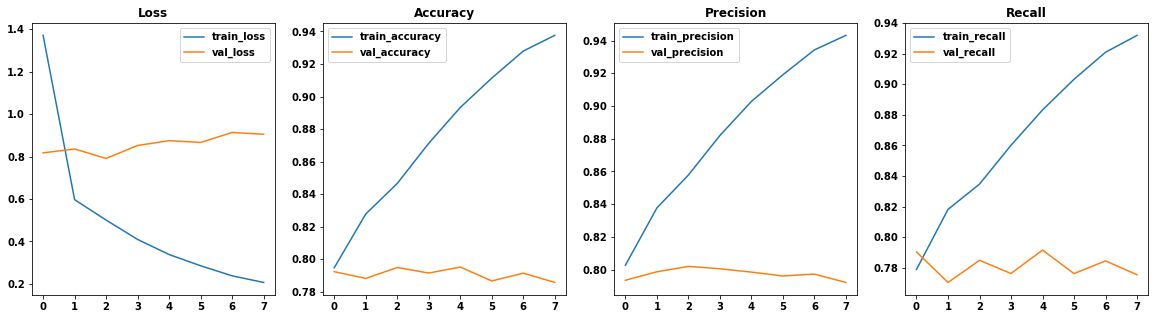

In [56]:
display_mode_trainTestGraphs(results)

Validation loss from the very beginning never improved and overall accuracy went down

In [33]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2'])

In [43]:
ax1

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    callbacks=callback,
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1
                    )

In [ ]:
display_mode_trainTestGraphs(results)

## Model 2

Increasing steps in epoch

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=150,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1
                    )

In [ ]:
display_mode_trainTestGraphs(results)

## Model: VGG16

## Model 3: DNN

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

In [ ]:
display_mode_trainTestGraphs(results)

## Adding a dropout layer and furthering depth

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

In [ ]:
display_mode_trainTestGraphs(results)

In [ ]:
## Increasing dropout rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

In [ ]:
display_mode_trainTestGraphs(results)

## Even deeeeeper NN

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

In [ ]:
# with dropout
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

In [ ]:
# with dropout
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

# Reducing multiple conv layers

In [ ]:
# with dropout
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

In [ ]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

In [ ]:
display_mode_trainTestGraphs(results)

In [ ]:
# reducing learning rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

In [ ]:
display_mode_trainTestGraphs(results)

In [ ]:
# reducing learning rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [ ]:
# reducing learning rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.Conv2D(512, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])



results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_mode_trainTestGraphs(results)

In [ ]:
model.summary()